### Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import warnings; warnings.simplefilter('ignore')
import matplotlib.lines as mlines
import scipy.signal

from PIL import Image
import math

## Image Rectification with Homography (Projective Transformation)

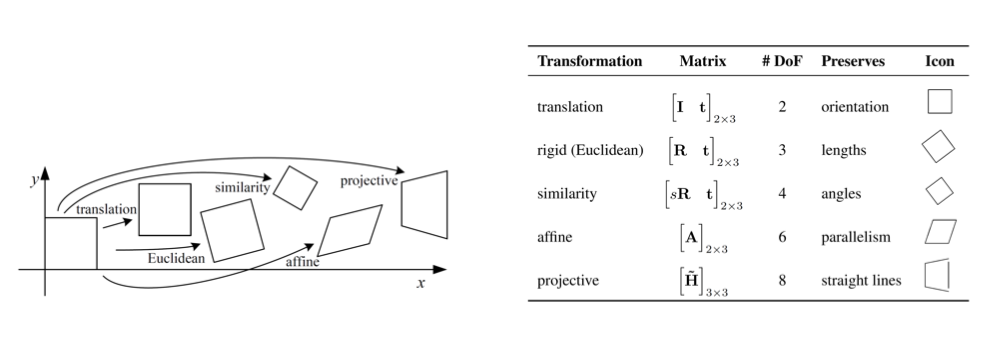

In [2]:
def loadImageAndCorners(imPath, txtPath, cHeight, cLen, frameMag, rowMinFrac, rowMaxFrac, colMinFrac):
    '''
    Load in manually labeled coordinates and calculate corresponding coordinates in transformed image.
    
    We need four such correspondances to solve form the Homography matrix/projective transformation.
    '''
    
    ## Load the 4 corners in pixels and plot the points and use cv2.polylines to draw the polygon
    im = np.asarray(Image.open(imPath))

    corners = []
    with open(txtPath,'r') as inf:
        for line in inf:
            corners.append(eval(line))
    
    # Read manually labeled corner locations:
    corners = corners[0]
    pLL_ = np.array(corners['LL'])
    pLR_ = np.array(corners['LR'])
    pUR_ = np.array(corners['UR'])
    pUL_ = np.array(corners['UL'])

    # Plot corners as labeled:
    imCorner = cv2.polylines(im, [np.array([pLL_, pLR_, pUR_, pUL_])], True, (52, 235, 192), 4)
    imRows, imCols, _ = imCorner.shape
    
    # Assign UL and LL in transformed image:
    sLL_ = np.array([int(frameMag*imCols//colMinFrac), int(frameMag*imRows//rowMaxFrac)], np.int32)
    sUL_ = np.array([int(frameMag*imCols//colMinFrac), int(frameMag*imRows//rowMinFrac)], np.int32)
    
    # Use aspect ratio to place UR and UR in transformed image:
    aspectRatio = cLen/cHeight
    distLL_UL = np.linalg.norm(sLL_ - sUL_)
    distLL_LR = distLL_UL*aspectRatio
    sLR_ = np.array([sLL_[0] + distLL_LR, sLL_[1]], np.int32)
    sUR_ = np.array([sLL_[0] + distLL_LR, sUL_[1]], np.int32)
    
    return pLL_, pLR_, pUR_, pUL_, sLL_, sUL_, sLR_, sUR_, imCorner

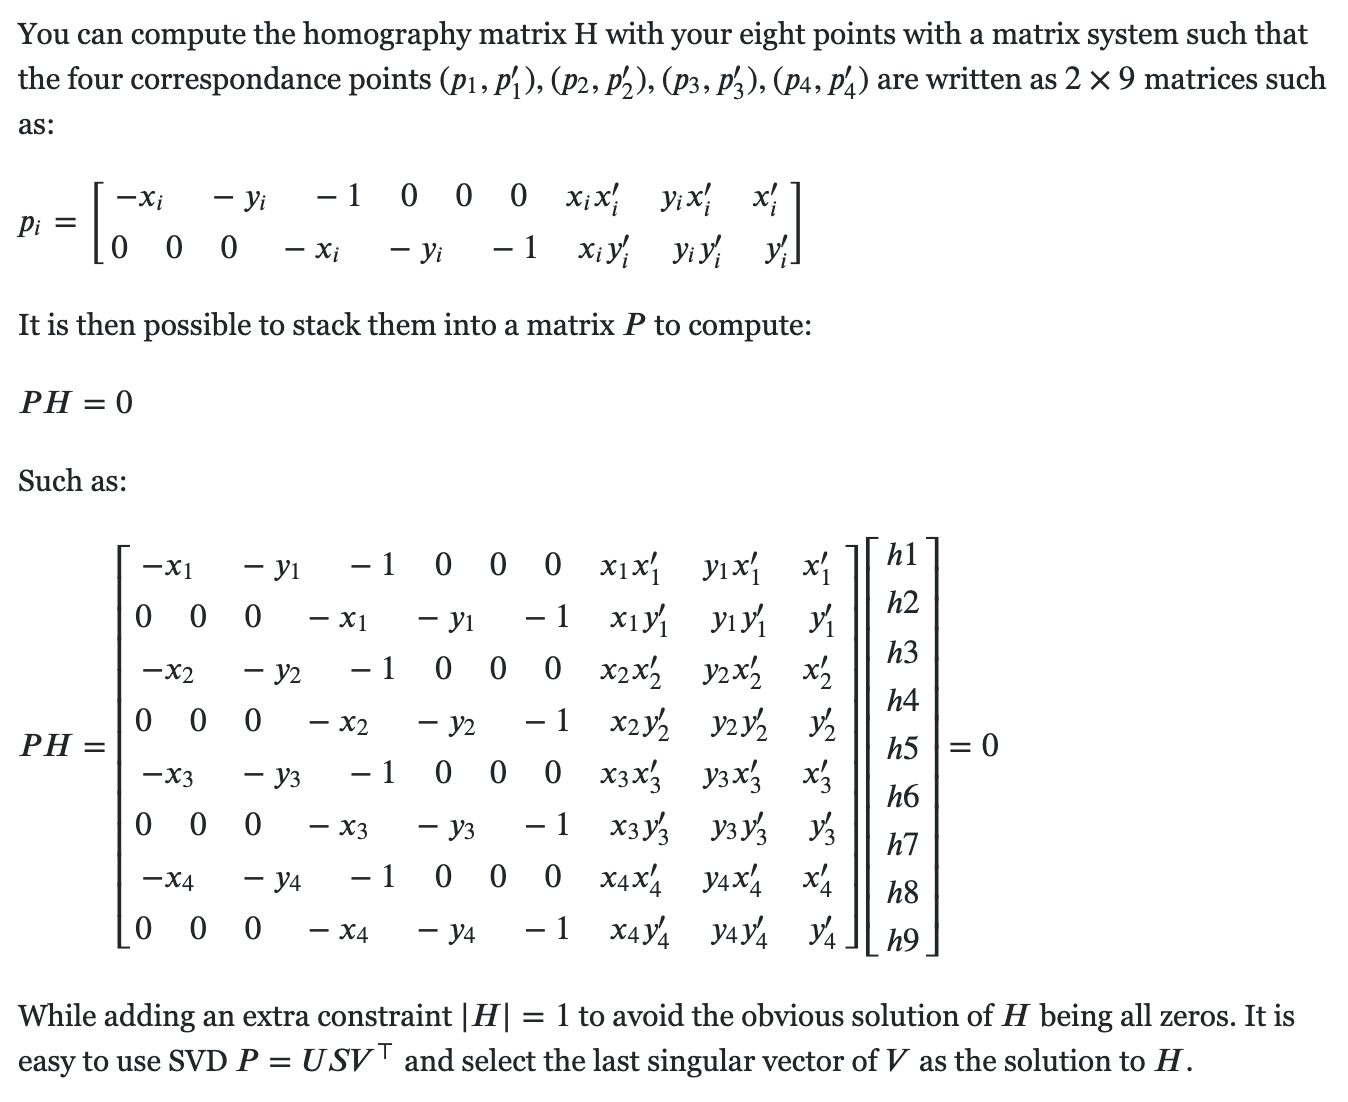

In [3]:
def calcProjective(x, y, hV):
    '''
    Apply homography matrix such that input x, y are transformed to output coordinates.
    '''
    
    hV = hV.reshape(-1,)
    sX = (hV[0]*x + hV[1]*y + hV[2])/(hV[6]*x + hV[7]*y + 1)
    sY = (hV[3]*x + hV[4]*y + hV[5])/(hV[6]*x + hV[7]*y + 1)

    # Note: Result cast to int to ensure a discrete pixel:
    return int(np.round(sX)), int(np.round(sY))

In [4]:
def solveHomographyTransform(pLL_, pLR_, pUR_, pUL_, sLL_, sUL_, sLR_, sUR_):
    ## Formulate and solve homogeneous equation:

    # Utilized following resources to check work:
    # https://math.stackexchange.com/questions/494238/how-to-compute-homography-matrix-h-from-corresponding-points-2d-2d-planar-homog
    # http://www.csc.kth.se/~perrose/files/pose-init-model/node17.html

    # Construct Coefficient Matrix:
    A = np.array([
                # From pLL_, sLL_
                [-pLL_[0], -pLL_[1], -1, 0, 0, 0, pLL_[0]*sLL_[0], pLL_[1]*sLL_[0], sLL_[0]],
                [0, 0, 0, -pLL_[0], -pLL_[1], -1, pLL_[0]*sLL_[1], pLL_[1]*sLL_[1], sLL_[1]],
                # From pLR_, sLR_
                [-pLR_[0], -pLR_[1], -1, 0, 0, 0, pLR_[0]*sLR_[0], pLR_[1]*sLR_[0], sLR_[0]],
                [0, 0, 0, -pLR_[0], -pLR_[1], -1, pLR_[0]*sLR_[1], pLR_[1]*sLR_[1], sLR_[1]],
                # From pUL_, sUL_
                [-pUL_[0], -pUL_[1], -1, 0, 0, 0, pUL_[0]*sUL_[0], pUL_[1]*sUL_[0], sUL_[0]],
                [0, 0, 0, -pUL_[0], -pUL_[1], -1, pUL_[0]*sUL_[1], pUL_[1]*sUL_[1], sUL_[1]],
                # From pUR_, sUR_
                [-pUR_[0], -pUR_[1], -1, 0, 0, 0, pUR_[0]*sUR_[0], pUR_[1]*sUR_[0], sUR_[0]],
                [0, 0, 0, -pUR_[0], -pUR_[1], -1, pUR_[0]*sUR_[1], pUR_[1]*sUR_[1], sUR_[1]]])

    # Find smallest eigenvalue/vector via numpy SVD utility:
    U, S, Vh = np.linalg.svd(A)
    h_ = Vh[-1, :].reshape(-1,1)/Vh[-1, -1]

    # Check that solution is essentially in null space:
    # (i.e. matrix product of A and h is close to [0, 0, 0].T)
    # Here we see sum of result_ting vector is 0.
    print('Valid Null Space Solution Check (should be close to 0):')
    print(np.sum(np.matmul(A, h_)))
    
    # Sanity check - should give our shifted point values:
    assert (sLL_[0], sLL_[1]) == calcProjective(pLL_[0], pLL_[1], h_)
    assert (sLR_[0], sLR_[1]) == calcProjective(pLR_[0], pLR_[1], h_)
    assert (sUL_[0], sUL_[1]) == calcProjective(pUL_[0], pUL_[1], h_)
    assert (sUR_[0], sUR_[1]) == calcProjective(pUR_[0], pUR_[1], h_)
    
    return h_

In [5]:
def transformFullImage(image_, h_, frameExpand_):
    '''
    Apply OpenCV function warpPerspective to image using known homography transform h.
    https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87
    '''
    projImFinal = cv2.warpPerspective(image_, 
                                      h_.reshape(3,3), 
                                      (int(frameExpand_[0]*image_.shape[1]), int(frameExpand_[1]*image_.shape[0])), 
                                      flags=cv2.INTER_LINEAR)

    plt.figure(figsize=(20, 40))

    plt.axis('off')
    plt.subplot(121),plt.imshow(imCorner),plt.title('Input')
    plt.axis('off')
    plt.subplot(122),plt.imshow(projImFinal/255),plt.title('Output')
    plt.axis('off')
    plt.show()

Valid Null Space Solution Check (should be close to 0):
5.401261660153978e-10


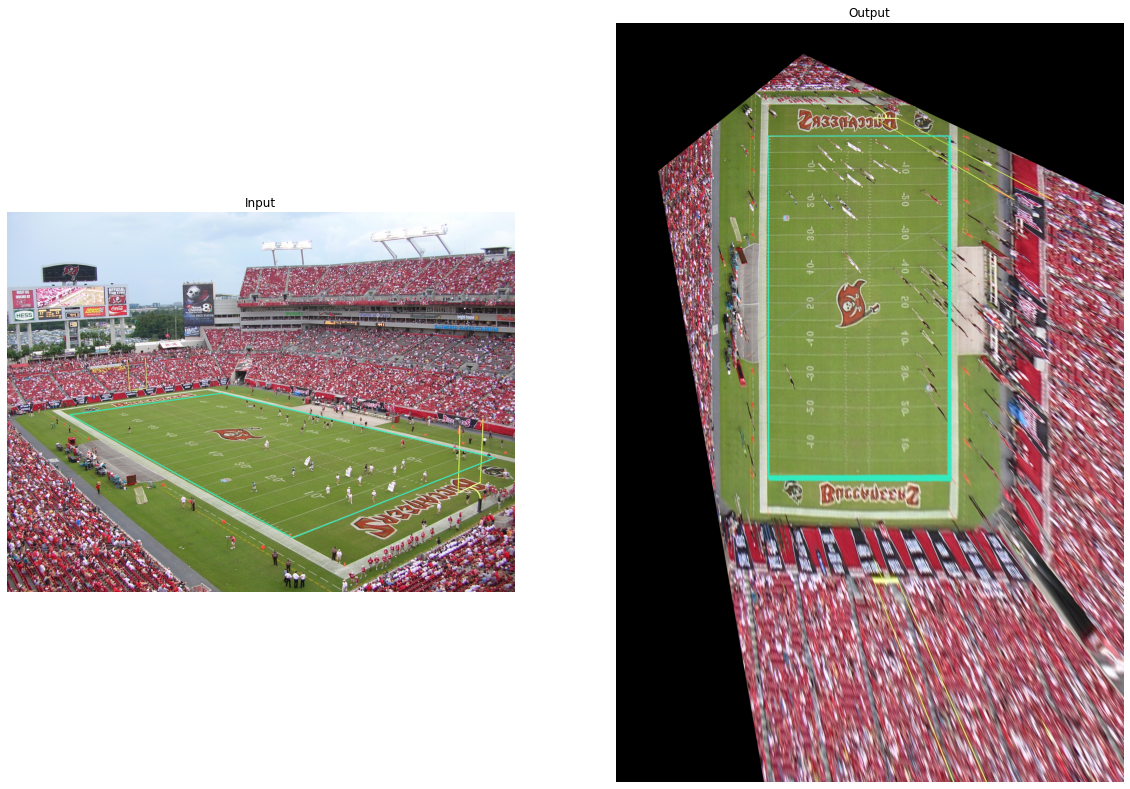

In [6]:
pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR, imCorner = loadImageAndCorners(imPath = 'stadium.png',
                                                                       txtPath = 'corners.txt',
                                                                       cHeight = 100,
                                                                       cLen = 53,
                                                                       frameMag = 1.5,
                                                                       rowMinFrac = 5,
                                                                       rowMaxFrac = 5/4,
                                                                       colMinFrac = 5)

h = solveHomographyTransform(pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR)

transformFullImage(imCorner, h, (1, 2))

Valid Null Space Solution Check (should be close to 0):
4.949924914399162e-09


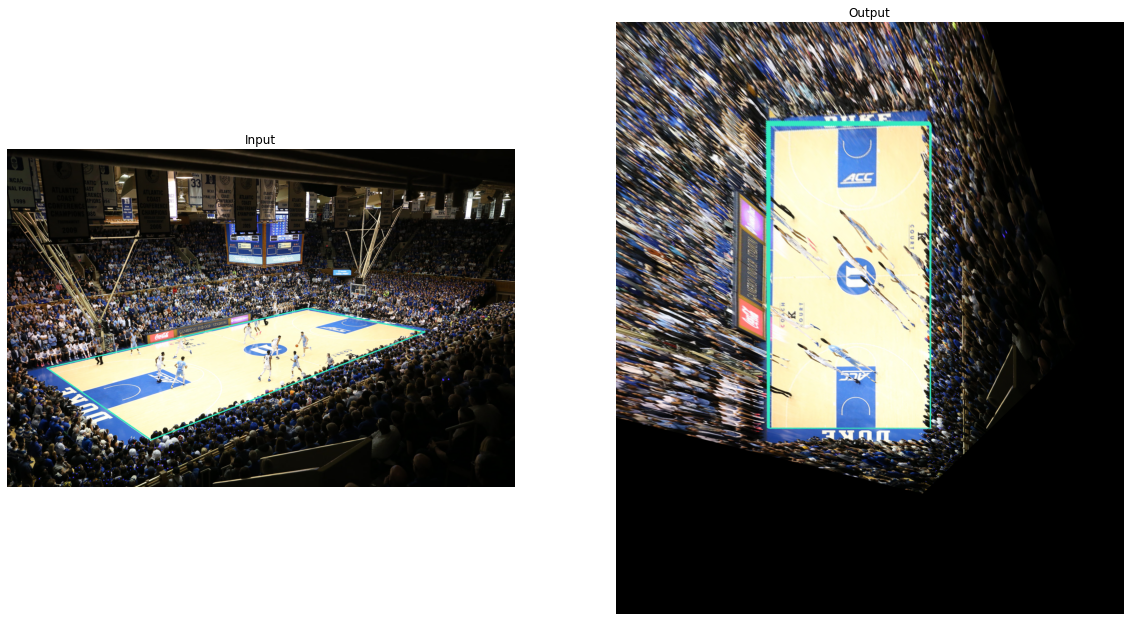

In [7]:
pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR, imCorner = loadImageAndCorners(imPath = 'duke.jpeg',
                                                                       txtPath = 'duke.txt',
                                                                       cHeight = 94,
                                                                       cLen = 50,
                                                                       frameMag = 1.5,
                                                                       rowMinFrac = 5,
                                                                       rowMaxFrac = 5/4,
                                                                       colMinFrac = 5)

h = solveHomographyTransform(pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR)

transformFullImage(imCorner, h, (1, 1.75))

Valid Null Space Solution Check (should be close to 0):
-1.6455032891826704e-09


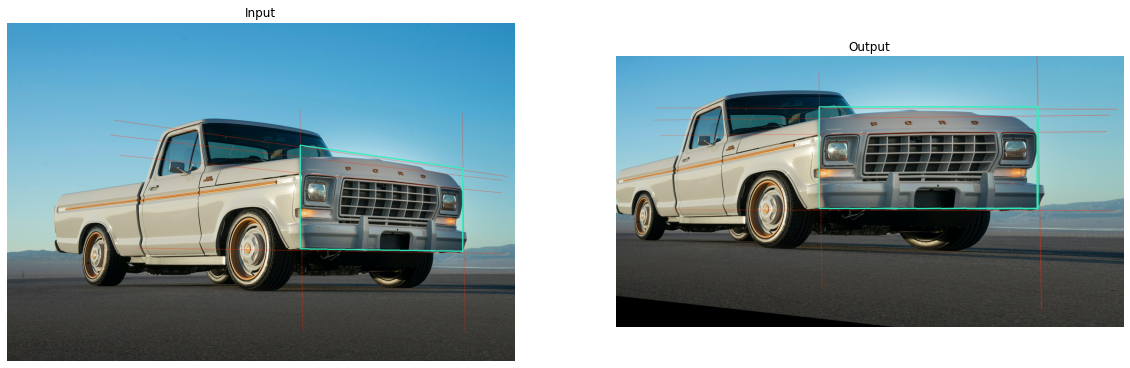

Valid Null Space Solution Check (should be close to 0):
2.641058927110862e-09


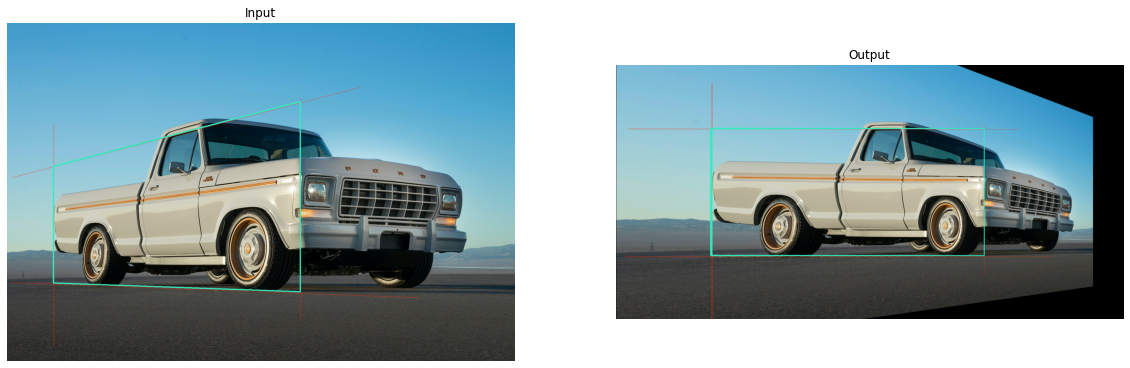

In [8]:
pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR, imCorner = loadImageAndCorners(imPath = 'ot3.jpeg',
                                                                       txtPath = 'ot3.txt',
                                                                       cHeight = 87,
                                                                       cLen = 187,
                                                                       frameMag = 1.5,
                                                                       rowMinFrac = 4,
                                                                       rowMaxFrac = 4/3,
                                                                       colMinFrac = 3/2)

h = solveHomographyTransform(pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR)

transformFullImage(imCorner, h, (2.5, 2))

pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR, imCorner = loadImageAndCorners(imPath = 'old truck.jpeg',
                                                                       txtPath = 'oldtruck.txt',
                                                                       cHeight = 87,
                                                                       cLen = 187,
                                                                       frameMag = 1.5,
                                                                       rowMinFrac = 4,
                                                                       rowMaxFrac = 4/3,
                                                                       colMinFrac = 4)

h = solveHomographyTransform(pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR)

transformFullImage(imCorner, h, (2, 1.5))

Valid Null Space Solution Check (should be close to 0):
9.250129551219288e-10


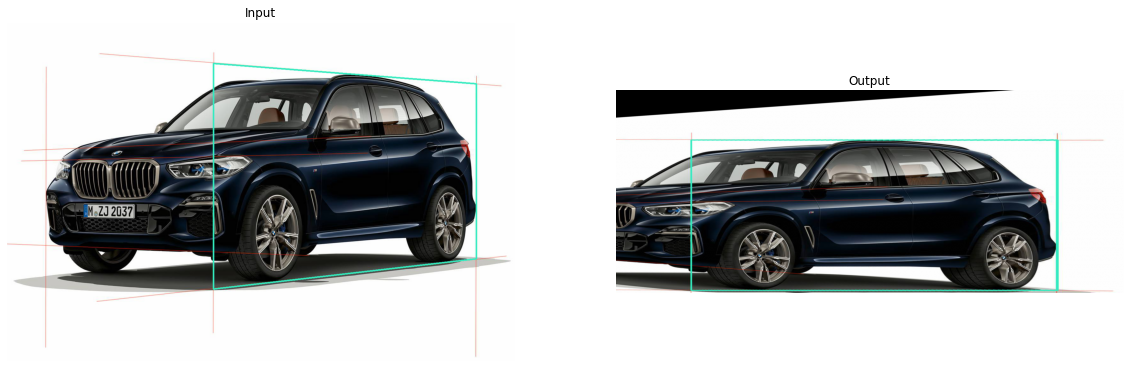

Valid Null Space Solution Check (should be close to 0):
4.104094841750339e-09


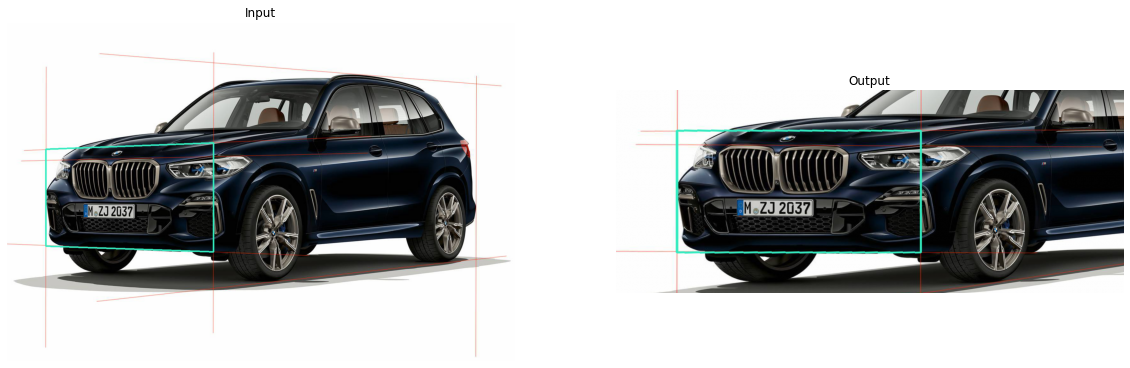

In [12]:
pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR, imCorner = loadImageAndCorners(imPath = 'bmw.jpeg',
                                                                       txtPath = 'bmw.txt',
                                                                       cHeight = 1762,
                                                                       cLen = 4286,
                                                                       frameMag = 1.85,
                                                                       rowMinFrac = 5,
                                                                       rowMaxFrac = 5/4,
                                                                       colMinFrac = 5)

h = solveHomographyTransform(pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR)

transformFullImage(imCorner, h, (2.5, 1.5))

pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR, imCorner = loadImageAndCorners(imPath = 'bmw.jpeg',
                                                                       txtPath = 'bmwFront.txt',
                                                                       cHeight = 100,
                                                                       cLen = 200,
                                                                       frameMag = 1.5,
                                                                       rowMinFrac = 5,
                                                                       rowMaxFrac = 5/4,
                                                                       colMinFrac = 5)

h = solveHomographyTransform(pLL, pLR, pUR, pUL, sLL, sUL, sLR, sUR)

transformFullImage(imCorner, h, (2.5, 1.5))

### Alternative Code to cv2.warpPerspective

In [10]:
## Commented out because it is slow relative to cv2 method and
## is not as clear, but appears to be correct. An interpolation
## step corrects many of the missing pixel mappings.

# def computeHomography(img, hVals):
    
#     projImg = np.zeros((img.shape[1], img.shape[0], 3))

#     for i in range(1, img.shape[0]):
#         for j in range(1, img.shape[1]):
            
#             y, x = calcProjective(j, i, hVals)
            
#             if x < projImg.shape[0] and y < projImg.shape[1] and x > 0 and y > 0:
#                 projImg[x, y, :] = img[i, j, :]

#     return projImg

# def simpleInterp(projImg, rounds):
    
#     for k in range(rounds):
#         for i in range(projImg.shape[0]):
#             for j in range(projImg.shape[1]):

#                 if np.sum(projImg[i, j, :]) == 0:
#                     try: 
#                         projImg[i, j, 0] = (.25)*(projImg[i-1, j, 0] + projImg[i, j-1, 0] + projImg[i+1, j, 0] + projImg[i, j+1, 0])
#                         projImg[i, j, 1] = (.25)*(projImg[i-1, j, 1] + projImg[i, j-1, 1] + projImg[i+1, j, 1] + projImg[i, j+1, 1])
#                         projImg[i, j, 2] = (.25)*(projImg[i-1, j, 2] + projImg[i, j-1, 2] + projImg[i+1, j, 2] + projImg[i, j+1, 2])
#                     except:
#                         continue
#     return projImg

# projIm = computeHomography(im, h)
# projImFinal = simpleInterp(projIm, 5)